In [ ]:
!unzip /data/Flickr8k_Dataset.zip > /dev/null
!unzip /data/Flickr8k_text.zip > /dev/null
!rm *.zip > /dev/null

In [ ]:
import os
import re
import gc
import numpy as np
import collections
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm_notebook as tqdm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add

In [ ]:
def clean_description(desc, stopwords):

  cleaned = desc.lower()
  cleaned = re.sub('[^a-z]',' ',cleaned)
  tokens = cleaned.split(' ')
  cleaned = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
  return cleaned

In [ ]:
def get_vocabulary(dictionary):
  vocab = set()

  for desc_list in dictionary.values():
    for desc in desc_list:
      words = desc.split(' ')
      for word in words:
        vocab.add(word)

  return vocab

In [ ]:
with open('/data/Flickr8k.token.txt', 'r') as f:
  all_desc = f.read().split('\n')

In [ ]:
# Some sample data
all_desc[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [ ]:
stopwords = ['is', 'an', 'a', 'the', 'was']

In [ ]:
all_dict = dict()

for desc in all_desc:
  if len(desc) < 1:
    continue
  file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
  if file_name not in all_dict.keys():
    all_dict[file_name] = []

  cleaned_desc = clean_description(file_desc, stopwords)
  cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

  all_dict[file_name].append(cleaned_desc)

In [ ]:
vocab = get_vocabulary(all_dict)

In [ ]:
print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 8092
Total vocabulary without stopwords: 8423


In [ ]:
!wget https://banner2.cleanpng.com/20181128/vpu/kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg > /dev/null

In [ ]:
mask = np.array(Image.open('kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg'))

wordcloud = WordCloud(width = 500, height = 400, 
                  background_color ='black', 
                  min_font_size = 10,
                  mask=mask, random_state=0).generate(' '.join(vocab)) 

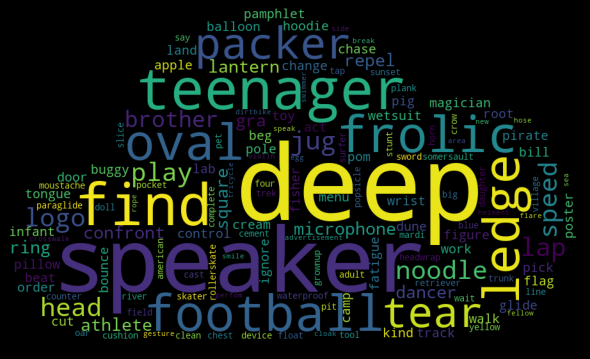

In [ ]:
plt.figure(figsize = (8, 8), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
all_sent_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]

In [ ]:
all_sent_len = [len(sent) for sent in all_sent_list]

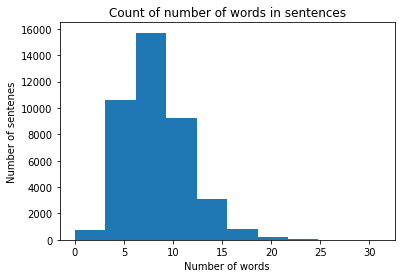

In [ ]:
plt.hist([len(sentence.split()) for sentence in all_sent_list])
plt.xlabel('Number of words')
plt.ylabel('Number of sentenes')
plt.title('Count of number of words in sentences')
plt.show()

In [ ]:
avg_sent_len = int(np.mean([len(sentence.split()) for sentence in all_sent_list]))
avg_sent_len

8

In [ ]:
words = [w for a in all_sent_list for w in a.split(' ')]

In [ ]:
counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]

[('in', 18987),
 ('on', 10746),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176)]

In [ ]:
keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

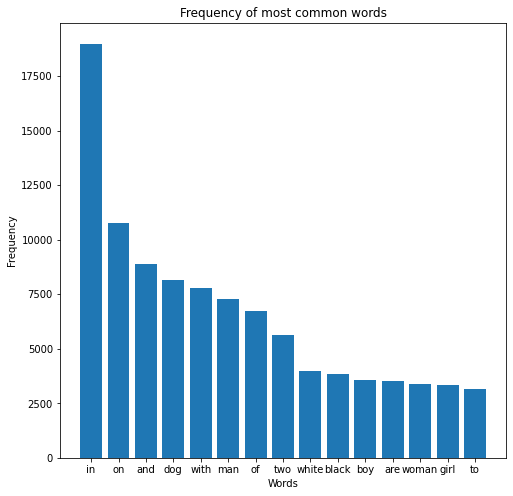

In [ ]:
plt.figure(figsize=(8, 8))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of most common words')
plt.show()

In [ ]:
lengths = set()
for cap_list in all_dict.values():
  lengths.add(len(cap_list))

print('Number of captions for each image: ', lengths)

Number of captions for each image:  {5}


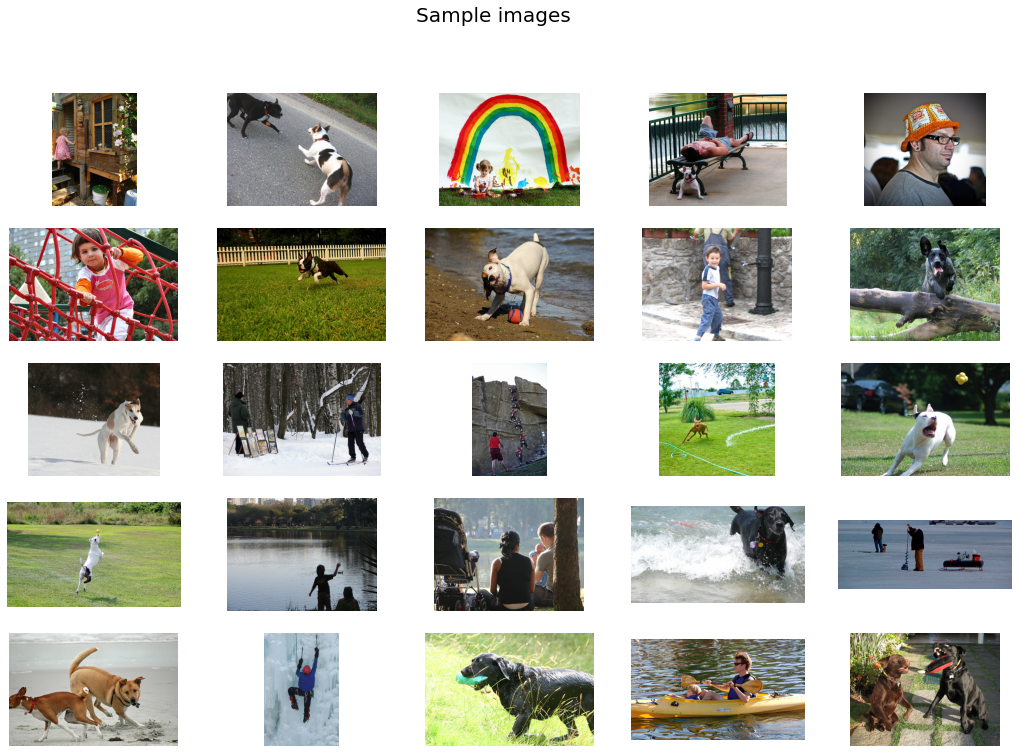

In [ ]:
fig = plt.figure()
fig.suptitle('Sample images', fontsize=20)

zoom = 3
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)
fig.tight_layout()

for i in range(1, 26):
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(plt.imread('Flicker8k_Dataset/'+list(all_dict.keys())[i-1]+'.jpg'))
  plt.axis('off')

plt.show()

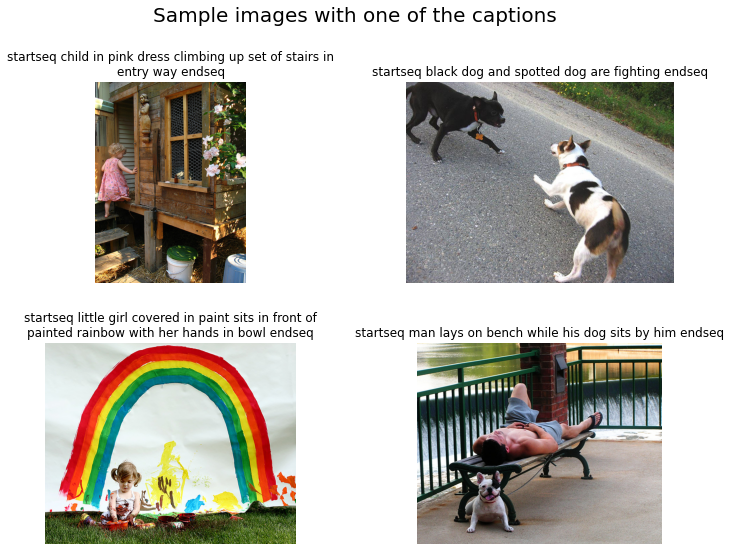

In [ ]:
fig = plt.figure()
fig.suptitle('Sample images with one of the captions', fontsize=20)

zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
  ax = fig.add_subplot(2, 2, i)
  ax.imshow(plt.imread('Flicker8k_Dataset/'+list(all_dict.keys())[i-1]+'.jpg'))
  title = ax.set_title('\n'.join(wrap(all_dict.get(list(all_dict.keys())[i-1])[0], 60)))
  fig.tight_layout(h_pad=2)
  title.set_y(1.05)
  plt.axis('off')
  fig.subplots_adjust(top=0.85, hspace=0.3)

plt.show()

In [ ]:
xcep = Xception(include_top=False, pooling='avg')

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
xcep.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
predictions = dict()

for dirpath, dirname, files in os.walk('Flicker8k_Dataset'):
  for filename in tqdm(files):
    img_path = os.path.join(dirpath, filename)
    if os.path.isfile(img_path):
      img = Image.open(img_path)
      img = img.resize((299,299))
      img = np.expand_dims(img, axis=0)
      img = img/127.5
      img = img - 1.0

      predictions[filename.split('.')[0]] = xcep.predict(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

Number of extracted features: 2048


In [ ]:
predictions.get(list(predictions.keys())[0])

array([[0.18308164, 0.63887495, 0.        , ..., 0.        , 0.00261217,
        0.12318476]], dtype=float32)

In [ ]:
def create_list(dictionary):
  final_list = []

  for desc_list in dictionary.values():
    for desc in desc_list:
      final_list.append(desc)

  return final_list

In [ ]:
def fit_tokenizer(dictionary):
  desc_list = create_list(dictionary)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

In [ ]:
def convert_to_input(tokens, pos, im_name, max_len, vocab_len, tokenizer, img_predictions):

  inp = tokens[:pos]
  out = tokens[pos]
  inp = pad_sequences(sequences=[inp], maxlen=max_len)[0]
  out = to_categorical(y=[out], num_classes=vocab_len, dtype='bool')[0]
  
  return img_predictions.get(im_name)[0], inp, out

In [ ]:
def convert_all_to_input(dictionary, max_len, vocab_len, tokenizer, img_predictions):
  
  X_1 = list()
  X_2 = list()
  y = list()

  for im_name, descriptions in tqdm(dictionary.items()):
    if im_name in img_predictions.keys():
      for desc in descriptions:
          tokens = tokenizer.texts_to_sequences([desc])[0]
          for i in range(1, len(tokens)):
              _X_1, _X_2, _y = convert_to_input(tokens, i, im_name, max_len, vocab_len, tokenizer, img_predictions)
              X_1.append(_X_1)
              X_2.append(_X_2)
              y.append(_y)
  return np.array(X_1), np.array(X_2), np.array(y)

In [ ]:
tokenizer = fit_tokenizer(all_dict)

In [ ]:
vocab_len = len(tokenizer.index_word) + 1
vocab_len

8423

In [ ]:
max_len = len(max(create_list(all_dict)))
max_len

93

In [ ]:
cnn_len = predictions[list(predictions.keys())[0]].shape[1]
cnn_len

2048

In [ ]:
X_1, X_2, y = convert_all_to_input(all_dict, max_len, vocab_len, tokenizer, predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
def shuffle_arrays(arrays, set_seed=-1):
    """Shuffles arrays in-place, in the same order, along axis=0

    Parameters:
    -----------
    arrays : List of NumPy arrays.
    set_seed : Seed value if int >= 0, else seed is random.
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [ ]:
shuffle_arrays([X_1, X_2, y])

In [ ]:
def create_model(cnn_len, max_len, vocab_len):
  cnn_in = Input(shape=(cnn_len,))
  cnn_x = Dropout(0.5)(cnn_in)
  cnn_out = Dense(units=256, activation='relu')(cnn_x)

  lstm_in = Input(shape=(max_len,))
  lstm_x = Embedding(vocab_len, 256, mask_zero=True)(lstm_in)
  lstm_x = Dropout(0.5)(lstm_x)
  lstm_out = LSTM(256)(lstm_x)

  combined = add([cnn_out, lstm_out])
  combined_x = Dense(units=256, activation='relu')(combined)
  output = Dense(units=vocab_len, activation='softmax')(combined_x)

  model = Model(inputs=[cnn_in, lstm_in], outputs=output)

  return model

In [ ]:
model = create_model(cnn_len, max_len, vocab_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics=[tf.keras.metrics.categorical_accuracy])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 93)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 93, 256)      2156288     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

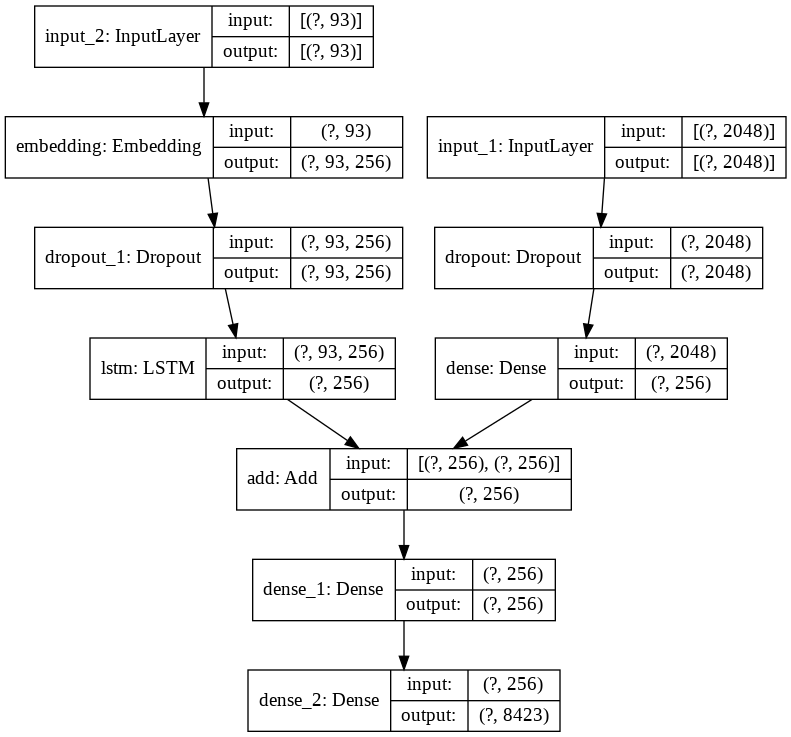

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train 4096 rows at a time to avoid memory overflow.

batch_size=4096

for i in tqdm(range(0, len(X_1), batch_size)):
  model.fit(x=[X_1[i:i+batch_size], X_2[i:i+batch_size]], y=y[i:i+batch_size], epochs=20, batch_size=256)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch 1/20
16/16 [==============================] - 0s 19ms/step - loss: 7.5215 - categorical_accuracy: 0.0801
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 5.8929 - categorical_accuracy: 0.0632
Epoch 3/20
16/16 [==============================] - 0s 20ms/step - loss: 5.6400 - categorical_accuracy: 0.1008
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 5.4891 - categorical_accuracy: 0.1184
Epoch 5/20
16/16 [==============================] - 0s 19ms/step - loss: 5.2971 - categorical_accuracy: 0.1355
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 5.0758 - categorical_accuracy: 0.1404
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 4.8344 - categorical_accuracy: 0.1511
Epoch 8/20
16/16 [==============================] - 0s 19ms/step - loss: 4.5970 - categorical_accuracy: 0.1621
Epoch 9/20
16/16 [==============================] - 0s 20ms/step - loss: 4.3281 - categorical_accuracy: 0.1758
E

### Inference

In [ ]:
def word_for_id(integer, tokenizer):

	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	
	return None

In [ ]:
def generate_desc(model, tokenizer, photo, max_len):
	
	start_text = 'startseq'

	for i in range(max_len):

		tokens = tokenizer.texts_to_sequences([start_text])[0]

		tokens = pad_sequences([tokens], maxlen=max_len)

		pred = model.predict([photo, tokens], verbose=0)

		pred = np.argmax(pred)

		word = word_for_id(pred, tokenizer)

		if word is None:
			break

		start_text += ' ' + word

		if word == 'endseq':
			break

	return start_text

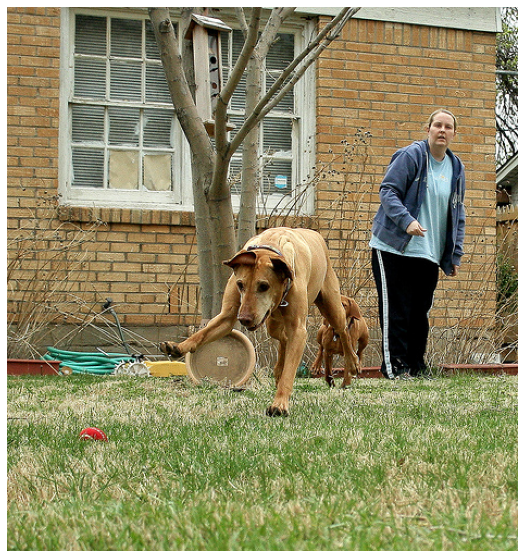

 brown dog runs across grass 


In [ ]:
img_path = 'test_images/test_1.png'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
pred = xcep.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenizer, pred, vocab_len)
caption = caption.strip('startseq').strip('endseq')
print(caption)

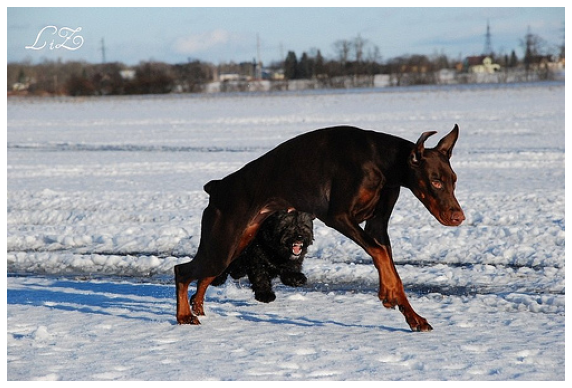

 brown dog running through snow 


In [ ]:
img_path = 'test_images/test_2.png'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
pred = xcep.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenizer, pred, vocab_len)
caption = caption.strip('startseq').strip('endseq')
print(caption)

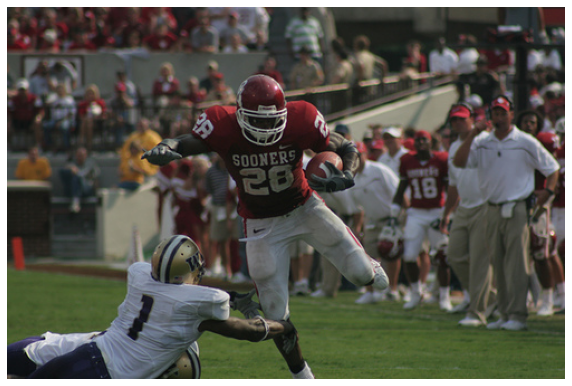

 football player in blue runs and red jersey in baseball match 


In [ ]:
img_path = 'test_images/test_3.png'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
pred = xcep.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenizer, pred, vocab_len)
caption = caption.strip('startseq').strip('endseq')
print(caption)

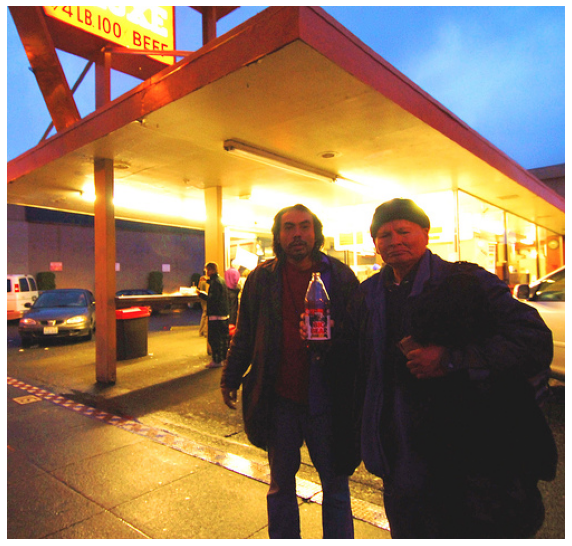

 man in black jacket standing in front of building 


In [ ]:
img_path = 'test_images/test_4.png'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
pred = xcep.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenizer, pred, vocab_len)
caption = caption.strip('startseq').strip('endseq')
print(caption)